[The detailed analysis](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) provided by the dataset author has helped in creating this kernel.  
Also [here's a link](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt) to the detailed description of the dataset.

These kernels were of great help to me:

* https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
* https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard 
* https://www.kaggle.com/apapiu/regularized-linear-models
* https://www.kaggle.com/humananalog/xgboost-lasso
* https://www.kaggle.com/poonaml/house-prices-data-exploration-and-visualisation

I am new to data science. It would be really awesome if you could tell me the mistakes and how I could improve the kernel in the comments below.

Here's the approach that I take in this kernel:

**1. Data Exploration -**
    Here, I separate out the features as belonging to one of the 3 classes -
    
    * `num_cont_columns` for numerical continuous features
    * `num_discrete_columns` for numerical discrete features
    * `categ_columns` for categorical features
       
   I do this because there are different steps of preprocessing required for each of those features. By separating them, I am able to create a clean analysis of the data.

**2. Preprocessing -**
    As I said, I divide the preprocessing stage in 3 steps where I analyse-
    
     * Continuous valued numeric features
     * Discrete valued numeric features
     * And finally, the Categorical features
        
   In each of those steps, I do the missing values imputation and feature engineering as required.

**3. Modelling -**

   I will train the following regression models -
    * Simple regression
    * Ridge regression
    * ElasticNet regression
    * Lasso regression
    
   And the following ensemble models - 
    * Random Forest
    * XGBoost
    
    Finally, I took the top 3 best performing models and stacked them up for the final submission model.

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction import FeatureHasher
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [102]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

train_id = df_train['Id']
test_id = df_test['Id']

df_train.drop(columns=['Id'], inplace=True)
df_test.drop(columns=['Id'], inplace=True)

ntrain = df_train.shape[0]
ntest = df_test.shape[0]

all_data = pd.concat((df_train, df_test)).reset_index(drop=True)

In [103]:
print(df_test.shape, df_train.shape, all_data.shape)
print(df_test.shape[0] + df_train.shape[0])

(1459, 79) (1460, 80) (2919, 80)
2919


# 1. Data exploration:

In [104]:
# see the decoration
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [105]:
# do this in order to view all the columns, otherwise pandas just shows a summary
pd.set_option('display.max_columns', None) 

# Lets see what the data looks like
df_train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [106]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There are a total of 80 unique features in the dataset.

In the detailed description that the dataset, the author divided the features into 4 types:

* Numerical:
   3. Discrete (14)
   4. Continuous (20)
* Categorical:
   1. Nominal (23)
   2. Ordinal (23)

Total no. of Categorical features = 23+23 = 46   
Total no. of Numerical features = 14 + 20 = 34

## 1.1. Separate the numerical and categorical features

In [107]:
# Separate out all the numeric features in the data
num_columns = df_train._get_numeric_data().columns
print(num_columns)
print(len(num_columns))

# Separate out all the non-numeric features in the data
categ_columns = pd.Index(list(set(df_train.columns) - set(num_columns)))
print(categ_columns)
print(len(categ_columns))

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
37
Index(['RoofMatl', 'HeatingQC', 'MasVnrType', 'LotShape', 'FireplaceQu',
       'MiscFeature', 'LotConfig', 'Condition1', 'Alley', 'Street',
       'BsmtExposure', 'BsmtFinType1', 'Heating', 'RoofStyle', 'BsmtCond',
       'GarageQual', 'ExterQual', 'GarageFinish', 'GarageCond', 'LandSlope',
       'BldgType', 'Neighborhood', 'PavedDrive', 'KitchenQual', 'ExterCond',
       'Foundation', 'CentralAir', 

We notice that MSSubClass, OverallQual and OverallCond take numeric values but are actually categorical in nature.

In [108]:
# moving features from num_columns to categ_columns
categ_columns = categ_columns.append(pd.Index(['MSSubClass', 'OverallQual', 'OverallCond']))
num_columns = num_columns.drop(['MSSubClass', 'OverallQual', 'OverallCond'])

In [109]:
print(len(num_columns), len(categ_columns))

34 46


## 1.2. Numerical features - *up close*

In [110]:
df_train[num_columns].head(5)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


### 1.2.1. Separating out the continuous and discrete features:

Lets look at the number of unique values that each numeric feature takes

In [111]:
def barplot_with_anotate(feature_list, y_values):
    x_pos = np.arange(len(feature_list))

    plt.bar(x_pos, y_values);
    plt.xticks(x_pos, feature_list, rotation=270);
    for i in range(len(feature_list)):
        plt.text(x=x_pos[i]-0.3, y=y_values[i]+1.0, s=y_values[i])

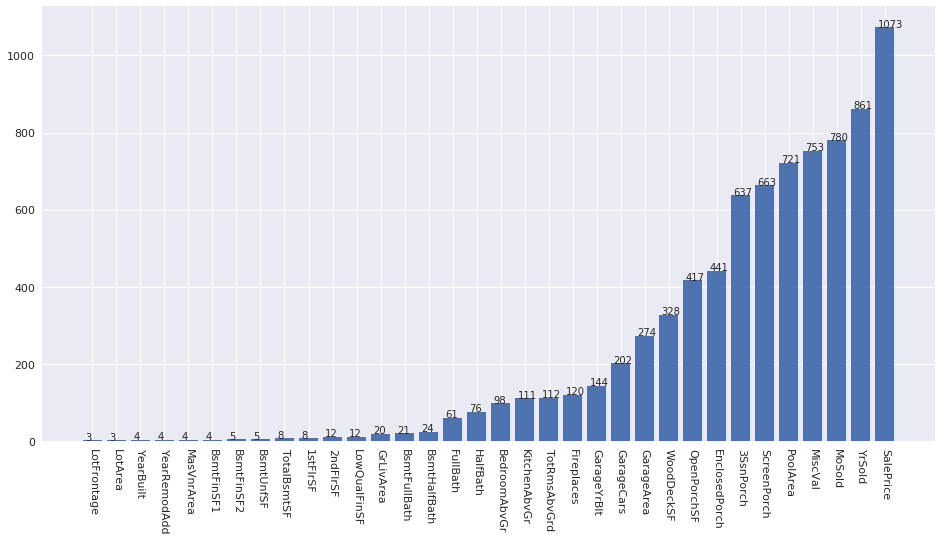

In [119]:
feature_lengths_sorted = sorted([len(df_train[feature].unique()) for feature in num_columns])
barplot_with_anotate(num_columns, feature_lengths_sorted)
plt.rcParams["figure.figsize"] = [16, 8]

After eyeballing the previous output, we can observe that all the features that take on less than 30 unique values throughout the dataset are discrete. Let's separate them out.

In [120]:
num_discrete_columns = []

for feature in num_columns:
    feature_len = len(df_train[feature].unique())
    if feature_len < 30:
        num_discrete_columns.append(feature)
num_discrete_columns = pd.Index(num_discrete_columns)
num_cont_columns = pd.Index(list(set(num_columns) - set(num_discrete_columns)))

In [121]:
# print the details of those discrete valued features
for feature in num_discrete_columns:
    feature_len = len(df_train[feature].unique())
    print(feature, feature_len)
    print(df_train[feature].unique())

LowQualFinSF 24
[  0 360 513 234 528 572 144 392 371 390 420 473 156 515  80  53 232 481
 120 514 397 479 205 384]
BsmtFullBath 4
[1 0 2 3]
BsmtHalfBath 3
[0 1 2]
FullBath 4
[2 1 3 0]
HalfBath 3
[1 0 2]
BedroomAbvGr 8
[3 4 1 2 0 5 6 8]
KitchenAbvGr 4
[1 2 3 0]
TotRmsAbvGrd 12
[ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces 4
[0 1 2 3]
GarageCars 5
[2 3 1 0 4]
3SsnPorch 20
[  0 320 407 130 180 168 140 508 238 245 196 144 182 162  23 216  96 153
 290 304]
PoolArea 8
[  0 512 648 576 555 480 519 738]
MiscVal 21
[    0   700   350   500   400   480   450 15500  1200   800  2000   600
  3500  1300    54   620   560  1400  8300  1150  2500]
MoSold 12
[ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold 5
[2008 2007 2006 2009 2010]


In [122]:
# The features LowQualFinSF, 3SsnPorch, PoolArea, MiscVal 
# belong to the list of continous features as they take on values from a continous distribution.
num_cont_columns = num_cont_columns.append(pd.Index(['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']))
num_discrete_columns = num_discrete_columns.drop(['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal'])

In [123]:
# print the details of the continuous valued features
for feature in sorted(num_cont_columns, key=lambda feature: len(df_train[feature].unique()), reverse=True):
    feature_len = len(df_train[feature].unique())
    print(feature, feature_len)

LotArea 1073
GrLivArea 861
BsmtUnfSF 780
1stFlrSF 753
TotalBsmtSF 721
SalePrice 663
BsmtFinSF1 637
GarageArea 441
2ndFlrSF 417
MasVnrArea 328
WoodDeckSF 274
OpenPorchSF 202
BsmtFinSF2 144
EnclosedPorch 120
YearBuilt 112
LotFrontage 111
GarageYrBlt 98
ScreenPorch 76
YearRemodAdd 61
LowQualFinSF 24
MiscVal 21
3SsnPorch 20
PoolArea 8


In [124]:
# The 3 year related features - YearBuilt, GarageYrBlt and YearRemodAdd belong to the list of discrete features.
num_discrete_columns = num_discrete_columns.append(pd.Index(['YearBuilt', 'GarageYrBlt', 'YearRemodAdd']))
num_cont_columns = num_cont_columns.drop(['YearBuilt', 'GarageYrBlt', 'YearRemodAdd'])

## 1.3. Categorical features - *up close*:

In [125]:
df_train[categ_columns].head(5)

,RoofMatl,HeatingQC,MasVnrType,LotShape,FireplaceQu,MiscFeature,LotConfig,Condition1,Alley,Street,BsmtExposure,BsmtFinType1,Heating,RoofStyle,BsmtCond,GarageQual,ExterQual,GarageFinish,GarageCond,LandSlope,BldgType,Neighborhood,PavedDrive,KitchenQual,ExterCond,Foundation,CentralAir,Electrical,BsmtFinType2,Exterior1st,Condition2,Functional,Fence,HouseStyle,SaleCondition,MSZoning,BsmtQual,GarageType,Exterior2nd,SaleType,Utilities,LandContour,PoolQC,MSSubClass,OverallQual,OverallCond
0,CompShg,Ex,BrkFace,Reg,NaN,NaN,Inside,Norm,NaN,Pave,No,GLQ,GasA,Gable,TA,TA,Gd,RFn,TA,Gtl,1Fam,CollgCr,Y,Gd,TA,PConc,Y,SBrkr,Unf,VinylSd,Norm,Typ,NaN,2Story,Normal,RL,Gd,Attchd,VinylSd,WD,AllPub,Lvl,NaN,60,7,5
1,CompShg,Ex,None,Reg,TA,NaN,FR2,Feedr,NaN,Pave,Gd,ALQ,GasA,Gable,TA,TA,TA,RFn,TA,Gtl,1Fam,Veenker,Y,TA,TA,CBlock,Y,SBrkr,Unf,MetalSd,Norm,Typ,NaN,1Story,Normal,RL,Gd,Attchd,MetalSd,WD,AllPub,Lvl,NaN,20,6,8
2,CompShg,Ex,BrkFace,IR1,TA,NaN,Inside,Norm,NaN,Pave,Mn,GLQ,GasA,Gable,TA,TA,Gd,RFn,TA,Gtl,1Fam,CollgCr,Y,Gd,TA,PConc,Y,SBrkr,Unf,VinylSd,Norm,Typ,NaN,2Story,Normal,RL,Gd,Attchd,VinylSd,WD,AllPub,Lvl,NaN,60,7,5
3,CompShg,Gd,None,IR1,Gd,NaN,Corner,Norm,NaN,Pave,No,ALQ,GasA,Gable,Gd,TA,TA,Unf,TA,Gtl,1Fam,Crawfor,Y,Gd,TA,BrkTil,Y,SBrkr,Unf,Wd Sdng,Norm,Typ,NaN,2Story,Abnorml,RL,TA,Detchd,Wd Shng,WD,AllPub,Lvl,NaN,70,7,5
4,CompShg,Ex,BrkFace,IR1,TA,NaN,FR2,Norm,NaN,Pave,Av,GLQ,GasA,Gable,TA,TA,Gd,RFn,TA,Gtl,1Fam,NoRidge,Y,Gd,TA,PConc,Y,SBrkr,Unf,VinylSd,Norm,Typ,NaN,2Story,Normal,RL,Gd,Attchd,VinylSd,WD,AllPub,Lvl,NaN,60,8,5


In [126]:
# lets look at what the categorical features represent
for feature in sorted(categ_columns, key=lambda feature: len(df_train[feature].unique()), reverse=True):
    feature_len = len(df_train[feature].unique())
    print(feature, feature_len)
    print(df_train[feature].unique())

Neighborhood 25
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Exterior2nd 16
['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
Exterior1st 15
['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
MSSubClass 15
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual 10
[ 7  6  8  5  9  4 10  3  1  2]
Condition1 9
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
SaleType 9
['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']
OverallCond 9
[5 8 6 7 4 2 3 9 1]
RoofMatl 8
['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
C

In [127]:
# remove duplicate columns
num_cont_columns = num_cont_columns.drop_duplicates()
num_discrete_columns = num_discrete_columns.drop_duplicates()
categ_columns = categ_columns.drop_duplicates()

## 1.4. Summary:

In [128]:
print("Categorical columns: ", len(categ_columns))
print("Continuous-valued numeric columns: ", len(num_cont_columns))
print("Discrete-valued numeric columns: ", len(num_discrete_columns))
print("-"*10)
print("Total columns: ", df_train.shape[1])

Categorical columns:  46
Continuous-valued numeric columns:  20
Discrete-valued numeric columns:  14
----------
Total columns:  80


# 2. Preprocessing:
We handle the separate kinds of features in this order:  
* First, the continuous valued numeric features
* Second, discrete valued numeric features
* Third, categorical features, i.e, both nominal and ordinal features together

But first, the author of the dataset recommends that we drop the data points with GrLivArea > 4000 as these are outliers. 

In [129]:
df_train.drop(df_train[df_train["GrLivArea"] > 4000].index, inplace=True)
df_train.shape

ntrain = df_train.shape[0]
ntest = df_test.shape[0]

all_data = pd.concat((df_train, df_test)).reset_index(drop=True)

## 2.1. Continuous valued numeric features:

In [130]:
df_train[num_cont_columns].describe()

,LotArea,TotalBsmtSF,OpenPorchSF,1stFlrSF,GarageArea,GrLivArea,ScreenPorch,SalePrice,BsmtFinSF1,WoodDeckSF,LotFrontage,EnclosedPorch,MasVnrArea,BsmtUnfSF,2ndFlrSF,BsmtFinSF2,LowQualFinSF,3SsnPorch,PoolArea,MiscVal
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1197.000000,1456.000000,1448.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,10448.784341,1050.658654,46.221154,1157.108516,471.568681,1506.502060,15.102335,180151.233516,436.991071,93.833791,69.693400,22.014423,102.087707,566.990385,343.532967,46.677198,5.860577,3.418956,2.055632,43.608516
std,9860.763449,412.155715,65.352424,369.307331,211.986421,496.815378,55.828405,76696.592530,430.255052,125.192349,23.054474,61.192248,177.338930,442.197182,431.528915,161.522376,48.688904,29.357056,35.383772,496.799265
min,1300.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,34900.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7538.750000,795.000000,0.000000,882.000000,329.500000,1128.000000,0.000000,129900.000000,0.000000,0.000000,59.000000,0.000000,0.000000,222.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9468.500000,990.500000,24.000000,1086.000000,478.500000,1458.500000,0.000000,163000.000000,381.000000,0.000000,69.000000,0.000000,0.000000,477.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11588.000000,1293.750000,68.000000,1389.250000,576.000000,1775.250000,0.000000,214000.000000,706.500000,168.000000,80.000000,0.000000,164.250000,808.000000,728.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,215245.000000,3206.000000,547.000000,3228.000000,1390.000000,3627.000000,480.000000,625000.000000,2188.000000,857.000000,313.000000,552.000000,1600.000000,2336.000000,1818.000000,1474.000000,572.000000,508.000000,738.000000,15500.000000


### Fill in the missing values:

In [131]:
def missing_features(data, column_set):
    incomplete_features = {feature: data.shape[0]-sum(data[feature].value_counts())
                                   for feature in column_set
                                   if not sum(data[feature].value_counts()) == data.shape[0]}
    incomplete_features_sorted = sorted(incomplete_features, key=lambda feature: incomplete_features[feature], reverse=True)
    incompleteness = [round((incomplete_features[feature]/data.shape[0])*100, 2) for feature in incomplete_features_sorted]
    barplot_with_anotate(incomplete_features_sorted, incompleteness)
    plt.ylabel("Percentage (%) of values that are missing")
    plt.rcParams["figure.figsize"] = [16, 8]
    
    for feature, percentage in zip(incomplete_features_sorted, incompleteness):
        print(feature, incomplete_features[feature], "(", percentage, ")")

SalePrice 1459 ( 50.05 )
LotFrontage 486 ( 16.67 )
MasVnrArea 23 ( 0.79 )
TotalBsmtSF 1 ( 0.03 )
GarageArea 1 ( 0.03 )
BsmtFinSF1 1 ( 0.03 )
BsmtUnfSF 1 ( 0.03 )
BsmtFinSF2 1 ( 0.03 )


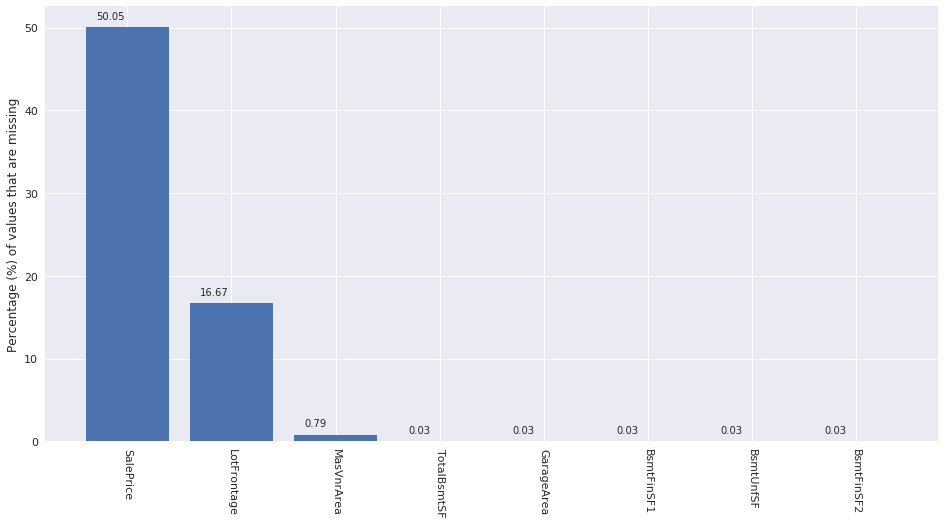

In [132]:
missing_features(all_data, num_cont_columns)

No columns are so empty that we need to drop them (I choose a 50% mark). Here's how we fill missing values:

* LotFrontage - *mean of the column*
* MasVnrArea, GarageArea, TotalBsmtSF, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF - 
    *0 (NA probably means that the features is absent)*

In [133]:
all_data.loc[:, 'LotFrontage'].fillna(all_data['LotFrontage'].mean(), inplace=True)

for feature in ['GarageArea', 'MasVnrArea', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']:
    all_data.loc[:, feature].fillna(0, inplace=True)

### Feature engineering

20


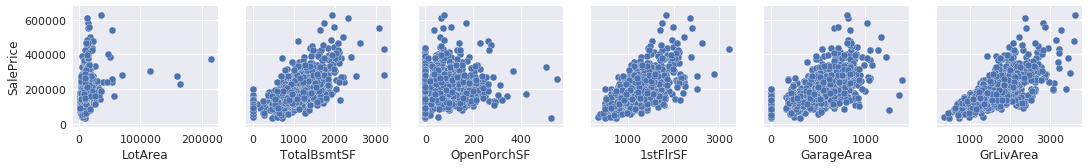

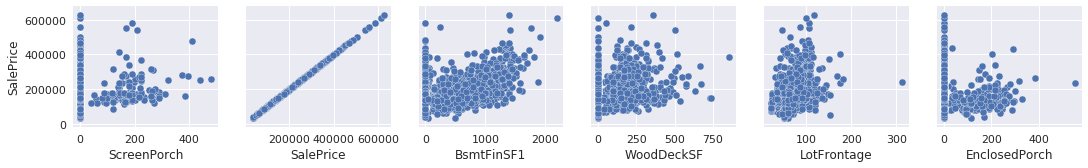

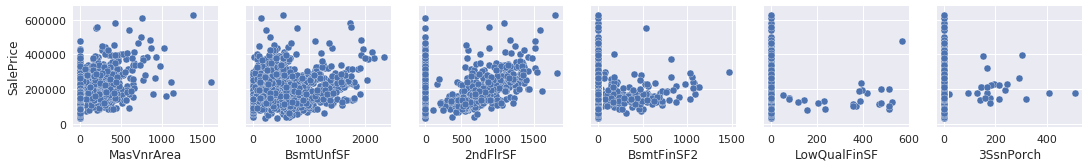

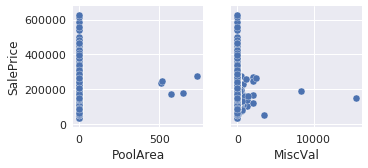

In [134]:
# first we view a scatter plot of each feature vs. SalePrice

num_cont_columns_list = list(num_cont_columns)

# show max of 6 features in each row
max_in_row = 6

print(len(num_cont_columns_list))
for i in range(0, len(num_cont_columns_list), max_in_row):
    sns.pairplot(df_train, x_vars=num_cont_columns_list[i:i+max_in_row], y_vars=['SalePrice'])

Correlation of each feature with SalePrice:
SalePrice        1.000000
GrLivArea        0.720516
TotalBsmtSF      0.646584
GarageArea       0.636964
1stFlrSF         0.625235
MasVnrArea       0.478862
BsmtFinSF1       0.395923
LotFrontage      0.356773
OpenPorchSF      0.330361
WoodDeckSF       0.322538
2ndFlrSF         0.297301
LotArea          0.269866
BsmtUnfSF        0.220678
ScreenPorch      0.118324
3SsnPorch        0.047414
PoolArea         0.032819
BsmtFinSF2      -0.008900
MiscVal         -0.021097
LowQualFinSF    -0.025351
EnclosedPorch   -0.129774
Name: SalePrice, dtype: float64


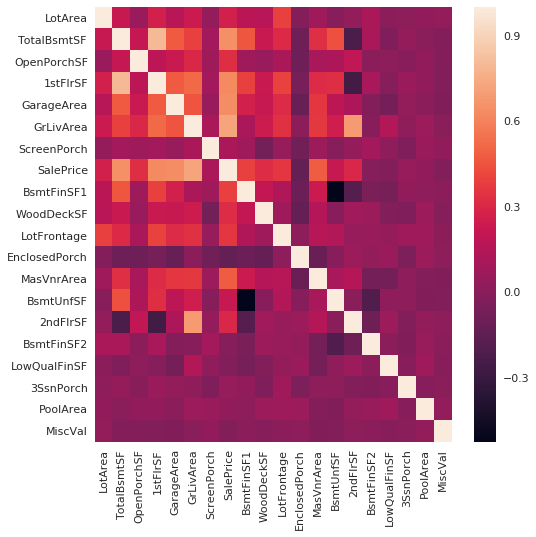

In [135]:
# then we see the correlations
print('Correlation of each feature with SalePrice:')
corr = df_train[num_cont_columns].corr()
corr_sorted = corr.sort_values(["SalePrice"], ascending = False)
print(corr_sorted['SalePrice'])

sns.set(font_scale=1.10)
plt.figure(figsize=(8, 8))

sns.heatmap(corr)

Upon eyballing the graphs and looking at the correlation table, it seems that LowQualFinSF, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, EnclosedPorch, BsmtFinSF2, LotFrontage, 2ndFlrSF by themselves don't have much correlation with the SalePrice.

__`OpenPorchSF`__ + __`EnclosedPorchSF`__ + __`3SsnPorch`__ + __`ScreenPorch`__

There are 4 "porch-area" related features - OpenPorchSF, EnclosedPorchSF, 3SsnPorch, ScreenPorch.   
Of these EnclosedPorch and 3SsnPorch have a small negative regression value while OpenPorchSF and ScreenPorch have small positive values.

Lets **combine them all and form a new feature**

In [136]:
all_data['TotPorchSF'] = all_data['OpenPorchSF'] + all_data['ScreenPorch'] + \
                         all_data['3SsnPorch'] + all_data['EnclosedPorch']
num_cont_columns = num_cont_columns.append(pd.Index(['TotPorchSF']))

__`PoolArea`__

PoolArea looks like it is mostly zero.

Lets have a look..

In [137]:
(df_train['PoolArea'] == 0).value_counts()

True     1451
False       5
Name: PoolArea, dtype: int64

It is highly skewed: the ratio of non-zero to zeros is less than 1/200. We're better off **dropping PoolArea**

In [138]:
all_data.drop(columns=['PoolArea'], inplace=True)
num_cont_columns = num_cont_columns.drop(['PoolArea'])

__`TotalBsmtSF + 1stFlrSF + 2ndFlrSF`__

Define a new feature - `TotalSF`

In [139]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
num_cont_columns = num_cont_columns.append(pd.Index(['TotalSF']))

And drop `TotalBsmtSF`, `1stFlrSF` and `2ndFlrSF`

In [140]:
all_data.drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], inplace=True)
num_cont_columns = num_cont_columns.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])

**Log-transform of `SalePrice`**

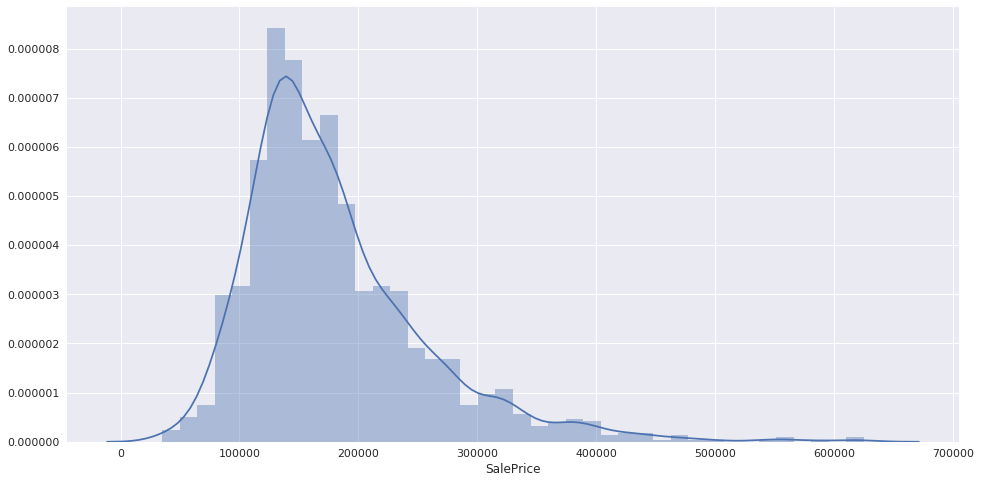

In [141]:
df_train = all_data[:ntrain][:]
sns.distplot(df_train['SalePrice'])

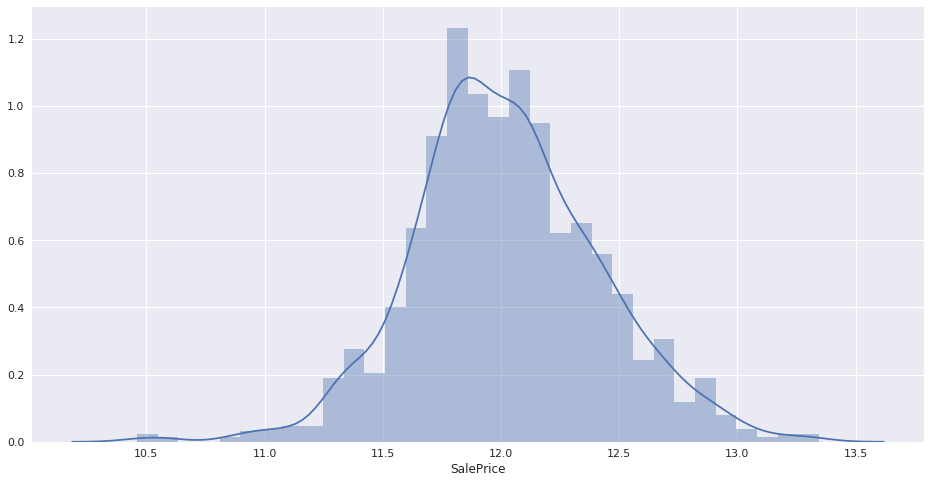

In [142]:
SalePriceLog = np.log1p(df_train['SalePrice'])
sns.distplot(SalePriceLog)

---------------

## 2.2. Discrete valued numeric features:

In [143]:
df_train[num_discrete_columns].describe()

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,MoSold,YrSold,YearBuilt,GarageYrBlt,YearRemodAdd
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.00000,1375.000000,1456.000000
mean,0.423764,0.057005,1.561813,0.381181,2.864698,1.046703,6.506181,0.609203,1.764423,6.326236,2007.817308,1971.18544,1978.440000,1984.819368
std,0.517420,0.237786,0.547683,0.502533,0.815800,0.220627,1.611800,0.640359,0.746215,2.698356,1.329394,30.20159,24.692738,20.652143
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,2006.000000,1872.00000,1900.000000,1950.000000
25%,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,5.000000,2007.000000,1954.00000,1961.000000,1966.750000
50%,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,6.000000,2008.000000,1972.00000,1980.000000,1993.500000
75%,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,8.000000,2009.000000,2000.00000,2002.000000,2004.000000
max,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,12.000000,2010.000000,2010.00000,2010.000000,2010.000000


### Filling in missing values:

GarageYrBlt 159 ( 5.45 )
BsmtFullBath 2 ( 0.07 )
BsmtHalfBath 2 ( 0.07 )
GarageCars 1 ( 0.03 )


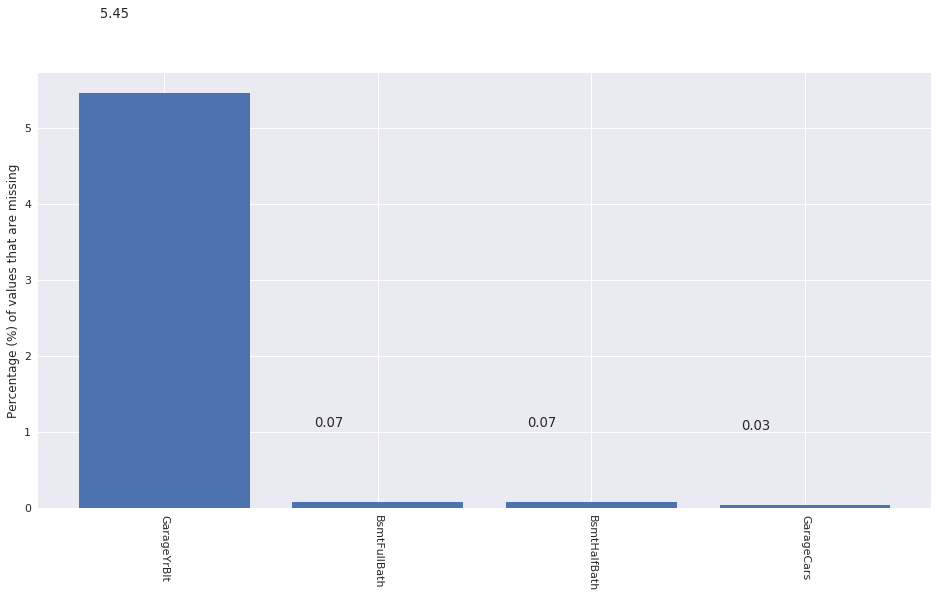

In [144]:
missing_features(all_data, num_discrete_columns)

* `GarageYrBlt`: We fill the missing values with the corresponding `YearBuilt` values (assume that the garage was built along with the house)
* `BsmtFullBath`: 0 (NaN probably means not present)
* `BsmtHalfBath`: 0 (NaN probably means not present)
* `GarageCars`: 0 (NaN probably means not present)

In [145]:
all_data.loc[:, 'GarageYrBlt'].fillna(all_data['YearBuilt'], inplace=True)
all_data.loc[:, 'BsmtFullBath'].fillna(0, inplace=True)
all_data.loc[:, 'BsmtHalfBath'].fillna(0, inplace=True)
all_data.loc[:, 'GarageCars'].fillna(0, inplace=True)

In [146]:
# print the details of those discrete valued features
for feature in num_discrete_columns:
    feature_len = len(df_train[feature].unique())
    print(feature, feature_len)
    print(df_train[feature].unique())

BsmtFullBath 4
[1. 0. 2. 3.]
BsmtHalfBath 3
[0. 1. 2.]
FullBath 4
[2 1 3 0]
HalfBath 3
[1 0 2]
BedroomAbvGr 8
[3 4 1 2 0 5 6 8]
KitchenAbvGr 4
[1 2 3 0]
TotRmsAbvGrd 12
[ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces 4
[0 1 2 3]
GarageCars 5
[2. 3. 1. 0. 4.]
MoSold 12
[ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold 5
[2008 2007 2006 2009 2010]
YearBuilt 112
[2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]
GarageYrBlt 102
[2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 19

In [147]:
print('Total: ', len(num_discrete_columns))
corr = df_train[list(num_discrete_columns) + ['SalePrice']].corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr['SalePrice'])

Total:  14
SalePrice       1.000000
GarageCars      0.649256
FullBath        0.559048
TotRmsAbvGrd    0.537462
YearBuilt       0.535279
YearRemodAdd    0.521428
GarageYrBlt     0.520632
Fireplaces      0.466765
HalfBath        0.282925
BsmtFullBath    0.235697
BedroomAbvGr    0.160542
MoSold          0.056797
YrSold         -0.023694
BsmtHalfBath   -0.036792
KitchenAbvGr   -0.138849
Name: SalePrice, dtype: float64


__`GarageArea`__:

Notice that GarageCars in this discrete variables list and GarageArea in continuous variables list, both convey the garage capacity. Since GarageCars has a higher correlation, we **drop GarageArea.**

In [148]:
all_data.drop(columns=['GarageArea'], inplace=True)
num_cont_columns = num_cont_columns.drop(['GarageArea'])

#### We change the date related features

It would be helpful if we could map the features that represent some date (like say, *1888*) to some small number (like say, *88*). 
There are 3 year related features - YearBuilt, YearRemodAdd, GarageYrBlt.


In [149]:
df_train[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt
count,1456.00000,1456.000000,1456.000000
mean,1971.18544,1984.819368,1976.439560
std,30.20159,20.652143,26.308749
min,1872.00000,1950.000000,1872.000000
25%,1954.00000,1966.750000,1959.000000
50%,1972.00000,1993.500000,1978.000000
75%,2000.00000,2004.000000,2001.000000
max,2010.00000,2010.000000,2010.000000


In [150]:
# Since the min of all 3 is 1872, we could replace their values with something like `year % 1872`

all_data['YearBuilt'] = all_data['YearBuilt'] % 1872
all_data['YearRemodAdd'] = all_data['YearRemodAdd'] % 1872
all_data['GarageYrBlt'] = all_data['GarageYrBlt'] % 1872

__`Bath`__ = __`FullBath`__ + 0.5*__`HalfBath`__

In [151]:
all_data['Bath'] = all_data['FullBath'] + 0.5*all_data['HalfBath']
all_data.drop(columns=['FullBath', 'HalfBath'], inplace=True)
num_discrete_columns = num_discrete_columns.drop(['FullBath', 'HalfBath'])

__`BsmtBath`__ = __`BsmtFullBath`__ + 0.5*__`BsmtHalfBath`__

In [152]:
all_data['BsmtBath'] = all_data['BsmtFullBath'] + 0.5*all_data['BsmtHalfBath']
all_data.drop(columns=['BsmtFullBath', 'BsmtHalfBath'], inplace=True)
num_discrete_columns = num_discrete_columns.drop(['BsmtFullBath', 'BsmtHalfBath'])

## 2.3. Categorical features:
### Preprocessing
#### Filling out the missing values -

PoolQC 2907 ( 99.73 )
MiscFeature 2810 ( 96.4 )
Alley 2717 ( 93.21 )
Fence 2345 ( 80.45 )
FireplaceQu 1420 ( 48.71 )
GarageQual 159 ( 5.45 )
GarageFinish 159 ( 5.45 )
GarageCond 159 ( 5.45 )
GarageType 157 ( 5.39 )
BsmtExposure 82 ( 2.81 )
BsmtCond 82 ( 2.81 )
BsmtQual 81 ( 2.78 )
BsmtFinType2 80 ( 2.74 )
BsmtFinType1 79 ( 2.71 )
MasVnrType 24 ( 0.82 )
MSZoning 4 ( 0.14 )
Functional 2 ( 0.07 )
Utilities 2 ( 0.07 )
KitchenQual 1 ( 0.03 )
Electrical 1 ( 0.03 )
Exterior1st 1 ( 0.03 )
Exterior2nd 1 ( 0.03 )
SaleType 1 ( 0.03 )


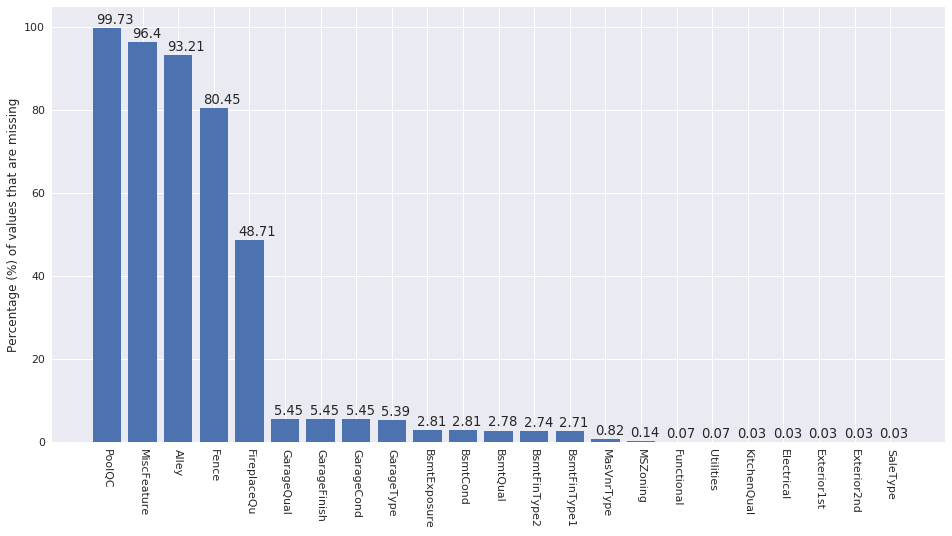

In [153]:
missing_features(all_data, categ_columns)

 The features are more than 50% empty - `PoolQC`, `MiscFeature`, `Alley`, `Fence`. Let's see their value counts.


In [154]:
for feature in ['PoolQC', 'MiscFeature', 'Alley', 'Fence']:
    print(df_train[feature].value_counts())

Gd    2
Fa    2
Ex    1
Name: PoolQC, dtype: int64
Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
MnPrv    156
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64


Points to note:
* We should drop `PoolQC` as it is mostly empty and because we have already dropped `PoolArea`
* The [feature description file](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt) says that `MiscFeature`, `Alley` and `Fence` have a value `NA` to represent the absence of those features. Yet, no datapoint has that value. This probably means that during the collecting of data, the person left this column blank instead of filling `NA`. So, we should take the empty values to mean `NA`
* `MiscFeature` is mostly just used to say the presence of Shed. So, we could replace it with a feature - `Shed`

In [155]:
# drop PoolQC
all_data.drop(columns=['PoolQC'], inplace=True)
categ_columns = categ_columns.drop(['PoolQC'])

# filling NA
all_data.fillna(value= {'MiscFeature': 'NA',
                        'Fence': 'NA',
                        'Alley': 'NA'}, inplace=True)

# Shed
all_data['Shed'] = all_data['MiscFeature'] == 'Shed'
all_data.drop(columns=['MiscFeature'], inplace=True)
categ_columns = categ_columns.drop(['MiscFeature'])
categ_columns = categ_columns.append(pd.Index(['Shed']))

In [156]:
filling_dict = {'FireplaceQu': 'NA',
                'GarageFinish': 'NA',
                'GarageQual': 'NA',
                'GarageType': 'NA',
                'GarageCond': 'NA',
                'BsmtExposure': 'NA',
                'BsmtFinType2': 'NA',
                'BsmtFinType1': 'NA',
                'BsmtCond': 'NA',
                'BsmtQual': 'NA',
                'MasVnrType': 'None',
                'Exterior1st': 'Other',
                'Exterior2nd': 'Other',
                'SaleType': 'Oth'}

for feature in ['Electrical', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual']:
    filling_dict[feature] = all_data[feature].mode().item()

In [157]:
# Now, handle the rest of the incomplete features
all_data.fillna(value=filling_dict, inplace=True)

#### Dropping features

In [158]:
# Neighborhood is an ordinal feature but we can't decide on the order responsibly unless we know the Ames city
# Hence we drop it
all_data.drop(columns=['Neighborhood'], inplace=True)
categ_columns = categ_columns.drop(['Neighborhood'])

In [159]:
# GarageQual and GarageCond measure the same thing
all_data.drop(columns=['GarageQual'], inplace=True)
categ_columns = categ_columns.drop(['GarageQual'])

In [160]:
# OverallQual and OverallCond seem to measure the same thing
# yet they have a very different correlation coefficient with SalePrice
df_train[['SalePrice', 'OverallQual', 'OverallCond']].corr()

,SalePrice,OverallQual,OverallCond
SalePrice,1.000000,0.800858,-0.080202
OverallQual,0.800858,1.000000,-0.090692
OverallCond,-0.080202,-0.090692,1.000000


In [161]:
# drop OverallCond
all_data.drop(columns=['OverallCond'], inplace=True)
categ_columns = categ_columns.drop(['OverallCond'])

#### More preprocessing -

#### `MSSubClass`

In [162]:
# new feature extraction
all_data["NewerDwelling"] = all_data["MSSubClass"].isin([20, 60, 120, 160])

In [163]:
# NewerDwelling, BldgType and HouseStyle together capture everything that MSSubClass can tell
# Hence we drop MSSubClass
all_data.drop(columns=['MSSubClass'], inplace=True)
categ_columns = categ_columns.drop(['MSSubClass'])

#### `MSZoning`

In [164]:
# simplity MSZoning as Residential or Non-residential
all_data['Residential'] = all_data['MSZoning'].isin(['RH', 'RL', 'RP', 'RM'])

# and drop MSZoning
all_data.drop(columns=['MSZoning'], inplace=True)
categ_columns = categ_columns.drop(['MSZoning'])

#### `Exterior1st` and `Exterior2nd`

In [165]:
# simplify Exterior1st and Exterior2nd 
print(df_train['Exterior1st'].value_counts())

VinylSd    515
HdBoard    221
MetalSd    220
Wd Sdng    205
Plywood    108
CemntBd     60
BrkFace     50
WdShing     26
Stucco      24
AsbShng     20
BrkComm      2
Stone        2
CBlock       1
ImStucc      1
AsphShn      1
Name: Exterior1st, dtype: int64


In [166]:
# We keep only the top 4 and move the rest to `Other`
all_data['Exterior1st'][-all_data['Exterior1st'].isin(all_data['Exterior1st'].value_counts().index[0:4])] \
    = 'Other'
all_data['Exterior2nd'][-all_data['Exterior2nd'].isin(all_data['Exterior1st'].value_counts().index[0:4])] \
    = 'Other'

#### `SaleType`

In [167]:
# simplify SaleType
all_data['SaleType'].value_counts()

WD       2523
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         8
Con         5
Name: SaleType, dtype: int64

In [168]:
# keep only the top 3 and move rest to `Oth`
all_data['SaleType'][-all_data['SaleType'].isin(all_data['SaleType'].value_counts().index[0:3])] = 'Oth'

#### `Functional`

In [169]:
# simplify Functional
all_data['Functional'][all_data['Functional'].isin(['Min1', 'Min2'])] = 'Min'
all_data['Functional'][all_data['Functional'].isin(['Maj1', 'Maj2'])] = 'Maj'

#### `GarageType`

In [170]:
# GarageType can either be Attchd or Detchd
# new feature - GarageDetchd
all_data['GarageDetchd'] = all_data['GarageType'].replace({'BuiltIn': 'Attchd', 
    'Basment': 'Attchd', 'CarPort': 'Attchd', '2Types': 'Detchd'})

# drop GarageType
all_data.drop(columns=['GarageType'], inplace=True)
categ_columns = categ_columns.drop(['GarageType'])

#### Transforming categorical features
* Ordered numbering - for ordinal features
* Some other numbering format - for nominal features

This way we help to prevent in embedding any false assumptions into our data because
* With ordered features there is a sense of structure and order in the values that those features take (for eg. - Excellent > Good > Poor)
* With nominal data if we use some order in the numbering, we embed false structure to our data 

In [171]:
# Step 1: Convert ordinal features to numbers
replace_dict =   {'LotShape': {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3},
                  'Utilities': {'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope': {'Sev': 0, 'Mod': 1, 'Gtl': 2},
                  'ExterQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
                  'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
                  'BsmtQual': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                  'BsmtCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                  'BsmtExposure': {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
                  'BsmtFinType2': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
                  'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
                  'Electrical': {'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4},
                  'KitchenQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
                  'Functional': {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6,
                                 'Typ': 7},
                  'FireplaceQu': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                  'GarageFinish': {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
                  'GarageCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                  'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
                  'Fence': {'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
                  'Condition1': {'Artery': 0, 'Feedr': 0, 'RRAn': 1, 'RRAe': 1, 'RRNn': 2, 'RRNe': 2, 
                                 'Norm': 5, 'PosA': 10, 'PosN': 11},
                  'Condition2': {'Artery': 0, 'Feedr': 0, 'RRAn': 1, 'RRAe': 1, 'RRNn': 2, 'RRNe': 2, 
                                 'Norm': 5, 'PosA': 10, 'PosN': 11}}
all_data = all_data.replace(replace_dict)

# all the other features of categ_columns are nominal
nominal_columns = categ_columns.drop(list(replace_dict.keys()))
nominal_columns = nominal_columns.drop(['OverallQual'])
ordinal_columns = pd.Series(list(replace_dict.keys()).append('OverallQual'))

In [172]:
# Step 2: One-hot encoding for nominal features
all_data = pd.get_dummies(all_data)

In [173]:
all_data.shape

(2915, 138)

## 2.4. Final feature engineering

### Creating newer features by combining existing ones

In [174]:
# BsmtFinType1 * BsmtFinSF1
all_data['BsmtFin1_Type*SF'] = all_data['BsmtFinType1'] * all_data['BsmtFinSF1']

# BsmtFinType2 * BsmtFinSF2
all_data['BsmtFin2_Type*SF'] = all_data['BsmtFinType2'] * all_data['BsmtFinSF2']

# ExterQual * ExterCond
all_data['Exter_Qual*Cond'] = all_data['ExterQual'] * all_data['ExterCond']

# KitchenQual * no. of kitchens
all_data['Kitchen_no*Qual'] = all_data['KitchenAbvGr'] * all_data['KitchenQual']

# Condition1 * Condition2
all_data['Condition1*Contition2'] = all_data['Condition1'] * all_data['Condition2']

# OverallQual * TotalSF
all_data['OverallQual*TotalSF'] = all_data['OverallQual'] * all_data['TotalSF']

# BsmtQual * BsmtCond * BsmtExposure
all_data['BsmtQual*Cond*Expo'] = all_data['BsmtQual'] * all_data['BsmtCond'] * all_data['BsmtExposure']

### Adding polynomials of the top 10 most correlated features

In [175]:
# get a list of the top 10 most correlated features
corr = all_data[all_data.columns].corr()
corr_sorted = corr.sort_values(["SalePrice"], ascending = False)
top10_features = list(corr_sorted['SalePrice'][1:11].keys())

In [176]:
# generate polynomial features and add to existing DataFrame
poly_features = PolynomialFeatures(degree=2, include_bias=False)
poly_features.fit_transform(all_data[top10_features])
poly_features.get_feature_names(top10_features)

poly_df = pd.DataFrame(poly_features.transform(all_data[top10_features]), 
                                     columns=poly_features.get_feature_names(top10_features))

all_data = pd.concat([all_data, poly_df], axis=1)

print("Final shape of data: ", all_data.shape)

Final shape of data:  (2915, 210)


This is what the new features look like:

In [177]:
poly_df.head(5)

,OverallQual*TotalSF,TotalSF,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,Bath,BsmtQual,Exter_Qual*Cond,OverallQual*TotalSF^2,OverallQual*TotalSF TotalSF,OverallQual*TotalSF OverallQual,OverallQual*TotalSF GrLivArea,OverallQual*TotalSF ExterQual,OverallQual*TotalSF KitchenQual,OverallQual*TotalSF GarageCars,OverallQual*TotalSF Bath,OverallQual*TotalSF BsmtQual,OverallQual*TotalSF Exter_Qual*Cond,TotalSF^2,TotalSF OverallQual,TotalSF GrLivArea,TotalSF ExterQual,TotalSF KitchenQual,TotalSF GarageCars,TotalSF Bath,TotalSF BsmtQual,TotalSF Exter_Qual*Cond,OverallQual^2,OverallQual GrLivArea,OverallQual ExterQual,OverallQual KitchenQual,OverallQual GarageCars,OverallQual Bath,OverallQual BsmtQual,OverallQual Exter_Qual*Cond,GrLivArea^2,GrLivArea ExterQual,GrLivArea KitchenQual,GrLivArea GarageCars,GrLivArea Bath,GrLivArea BsmtQual,GrLivArea Exter_Qual*Cond,ExterQual^2,ExterQual KitchenQual,ExterQual GarageCars,ExterQual Bath,ExterQual BsmtQual,ExterQual Exter_Qual*Cond,KitchenQual^2,KitchenQual GarageCars,KitchenQual Bath,KitchenQual BsmtQual,KitchenQual Exter_Qual*Cond,GarageCars^2,GarageCars Bath,GarageCars BsmtQual,GarageCars Exter_Qual*Cond,Bath^2,Bath BsmtQual,Bath Exter_Qual*Cond,BsmtQual^2,BsmtQual Exter_Qual*Cond,Exter_Qual*Cond^2
0,17962.0,2566.0,7.0,1710.0,3.0,3.0,2.0,2.5,4.0,6.0,322633444.0,46090492.0,125734.0,30715020.0,53886.0,53886.0,35924.0,44905.0,71848.0,107772.0,6584356.0,17962.0,4387860.0,7698.0,7698.0,5132.0,6415.0,10264.0,15396.0,49.0,11970.0,21.0,21.0,14.0,17.5,28.0,42.0,2924100.0,5130.0,5130.0,3420.0,4275.0,6840.0,10260.0,9.0,9.0,6.0,7.5,12.0,18.0,9.0,6.0,7.5,12.0,18.0,4.0,5.0,8.0,12.0,6.25,10.0,15.0,16.0,24.0,36.0
1,15144.0,2524.0,6.0,1262.0,2.0,2.0,2.0,2.0,4.0,4.0,229340736.0,38223456.0,90864.0,19111728.0,30288.0,30288.0,30288.0,30288.0,60576.0,60576.0,6370576.0,15144.0,3185288.0,5048.0,5048.0,5048.0,5048.0,10096.0,10096.0,36.0,7572.0,12.0,12.0,12.0,12.0,24.0,24.0,1592644.0,2524.0,2524.0,2524.0,2524.0,5048.0,5048.0,4.0,4.0,4.0,4.0,8.0,8.0,4.0,4.0,4.0,8.0,8.0,4.0,4.0,8.0,8.0,4.00,8.0,8.0,16.0,16.0,16.0
2,18942.0,2706.0,7.0,1786.0,3.0,3.0,2.0,2.5,4.0,6.0,358799364.0,51257052.0,132594.0,33830412.0,56826.0,56826.0,37884.0,47355.0,75768.0,113652.0,7322436.0,18942.0,4832916.0,8118.0,8118.0,5412.0,6765.0,10824.0,16236.0,49.0,12502.0,21.0,21.0,14.0,17.5,28.0,42.0,3189796.0,5358.0,5358.0,3572.0,4465.0,7144.0,10716.0,9.0,9.0,6.0,7.5,12.0,18.0,9.0,6.0,7.5,12.0,18.0,4.0,5.0,8.0,12.0,6.25,10.0,15.0,16.0,24.0,36.0
3,17311.0,2473.0,7.0,1717.0,2.0,3.0,3.0,1.0,3.0,4.0,299670721.0,42810103.0,121177.0,29722987.0,34622.0,51933.0,51933.0,17311.0,51933.0,69244.0,6115729.0,17311.0,4246141.0,4946.0,7419.0,7419.0,2473.0,7419.0,9892.0,49.0,12019.0,14.0,21.0,21.0,7.0,21.0,28.0,2948089.0,3434.0,5151.0,5151.0,1717.0,5151.0,6868.0,4.0,6.0,6.0,2.0,6.0,8.0,9.0,9.0,3.0,9.0,12.0,9.0,3.0,9.0,12.0,1.00,3.0,4.0,9.0,12.0,16.0
4,26744.0,3343.0,8.0,2198.0,3.0,3.0,3.0,2.5,4.0,6.0,715241536.0,89405192.0,213952.0,58783312.0,80232.0,80232.0,80232.0,66860.0,106976.0,160464.0,11175649.0,26744.0,7347914.0,10029.0,10029.0,10029.0,8357.5,13372.0,20058.0,64.0,17584.0,24.0,24.0,24.0,20.0,32.0,48.0,4831204.0,6594.0,6594.0,6594.0,5495.0,8792.0,13188.0,9.0,9.0,9.0,7.5,12.0,18.0,9.0,9.0,7.5,12.0,18.0,9.0,7.5,12.0,18.0,6.25,10.0,15.0,16.0,24.0,36.0


### Dropping uncorrelated features

We drop the features which have a `|correlation score| < 0.1`

In [178]:
# then we see the correlations
corr = all_data[all_data.columns].corr()
corr_sorted = corr.sort_values(["SalePrice"], ascending = False)

#corr_sorted['SalePrice'][0:50]
best_corr = corr_sorted[corr_sorted['SalePrice']>0.1]['SalePrice']
worst_corr = corr_sorted[corr_sorted['SalePrice']<-0.1]['SalePrice']
selected_corr = pd.concat([best_corr, worst_corr])

print(len(list(selected_corr)))
print(len(list(best_corr)), len(list(worst_corr)))

169
144 25


In [179]:
black_list = [elem for elem in list(all_data.columns) if elem not in list(selected_corr.keys())]
all_data.drop(columns=black_list, inplace=True)

all_data.shape

(2915, 149)

# 3. Modelling

In [180]:
all_data = all_data.loc[:,~all_data.columns.duplicated()]

**Divide the train data into `df_train` and `df_validate`.**

In [181]:
nvalidate = int(0.2 * ntrain)
ntrain = int(ntrain - nvalidate)

df_train = all_data[:ntrain][:]
df_validate = all_data[ntrain:ntrain+nvalidate][:]
df_test = all_data[ntrain+nvalidate:][:]
df_test = df_test.drop('SalePrice', axis=1)

In [182]:
print(df_train.shape)
print(df_validate.shape)
print(df_test.shape)
print(ntrain, nvalidate, ntest)

(1165, 139)
(291, 139)
(1459, 138)
1165 291 1459


**Separate the true `SalePrice` column from the rest of the data**

In [183]:
X_train= df_train.drop('SalePrice', axis= 1)
Y_train= df_train['SalePrice']
Y_train_log = SalePriceLog[:ntrain]

X_validate = df_validate.drop('SalePrice', axis=1)
Y_validate = df_validate['SalePrice']
Y_validate_log = SalePriceLog[ntrain:ntrain+nvalidate]

X_test= df_test

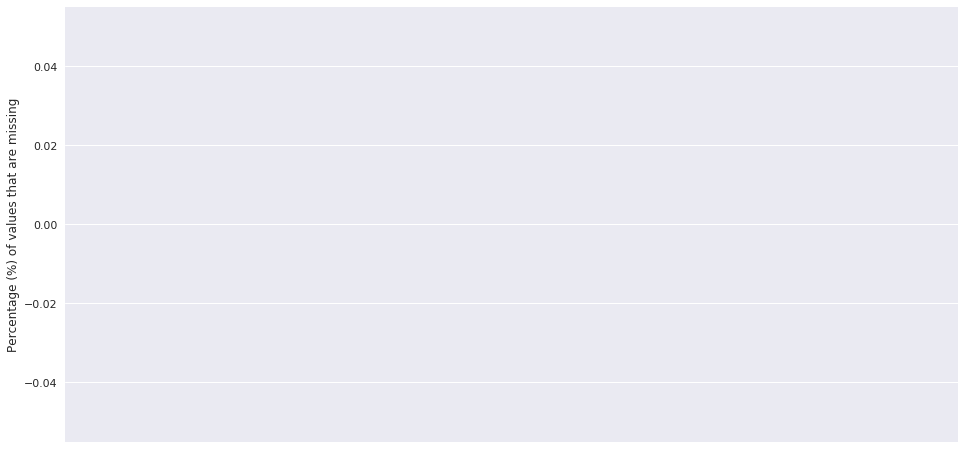

In [184]:
# make sure that there are no NaNs
missing_features(X_train, X_train.columns)
missing_features(X_test, X_test.columns)
missing_features(X_validate, X_validate.columns)

-------

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [186]:
def rmse_score(Y_true, Y_pred):
    return round(np.sqrt(mean_squared_error(np.log(Y_true), np.log(Y_pred))), 5)

### Linear Regression

In [187]:
linreg = LinearRegression(normalize=True)
linreg.fit(X_train, Y_train)

Y_train_pred = linreg.predict(X_train)
Y_train_pred[Y_train_pred < 1] = 1
Y_validate_pred = linreg.predict(X_validate)
Y_validate_pred[Y_validate_pred<1] = 1

acc_lin_train = rmse_score(Y_train.values, Y_train_pred)
acc_lin_validate = rmse_score(Y_validate.values, Y_validate_pred)

print("RMSE on train: ", acc_lin_train)
print("RMSE on validation: ", acc_lin_validate)

RMSE on train:  0.11099
RMSE on validation:  0.13512


In [188]:
linreg_on_log = LinearRegression(normalize=True)
linreg_on_log.fit(X_train, Y_train_log)

Y_train_pred = np.exp(linreg_on_log.predict(X_train))
Y_train_pred[Y_train_pred < 0] = 0
Y_validate_pred = np.exp(linreg_on_log.predict(X_validate))
Y_validate_pred[Y_validate_pred<0] = 0

acc_lin_train = rmse_score(Y_train.values, Y_train_pred)
acc_lin_validate = rmse_score(Y_validate.values, Y_validate_pred)

print("RMSE on train: ", acc_lin_train)
print("RMSE on validation: ", acc_lin_validate)

RMSE on train:  0.10817
RMSE on validation:  0.13249


### Lasso Regression

In [189]:
lasso = Lasso()
lasso.fit(X_train, Y_train)

acc_lasso_train = rmse_score(Y_train.values, lasso.predict(X_train))
acc_lasso_validate = rmse_score(Y_validate.values, lasso.predict(X_validate))

print("RMSE on train: ", acc_lasso_train)
print("RMSE on validation: ", acc_lasso_validate)

RMSE on train:  0.11164
RMSE on validation:  0.13245


In [190]:
lasso_on_log = Lasso()
lasso_on_log.fit(X_train, Y_train_log)

acc_lasso_train = rmse_score(Y_train.values, np.exp(lasso_on_log.predict(X_train)))
acc_lasso_validate = rmse_score(Y_validate.values, np.exp(lasso_on_log.predict(X_validate)))

print("RMSE on train: ", acc_lasso_train)
print("RMSE on validation: ", acc_lasso_validate)

RMSE on train:  0.14344
RMSE on validation:  0.14204


### Ridge Regression

In [191]:
ridge = Ridge()
ridge.fit(X_train, Y_train)

acc_ridge_train = rmse_score(Y_train.values, ridge.predict(X_train))
acc_ridge_validate = rmse_score(Y_validate.values, ridge.predict(X_validate))

print("RMSE on train: ", acc_ridge_train)
print("RMSE on validation: ", acc_ridge_validate)

RMSE on train:  0.1109
RMSE on validation:  0.13266


In [192]:
ridge_on_log = Ridge()
ridge_on_log.fit(X_train, Y_train_log)

acc_ridge_train = rmse_score(Y_train.values, np.exp(ridge_on_log.predict(X_train)))
acc_ridge_validate = rmse_score(Y_validate.values, np.exp(ridge_on_log.predict(X_validate)))

print("RMSE on train: ", acc_ridge_train)
print("RMSE on validation: ", acc_ridge_validate)

RMSE on train:  0.10862
RMSE on validation:  0.12982


### ElasticNet Regression

In [193]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, Y_train)

acc_en_train = rmse_score(Y_train.values, elastic_net.predict(X_train))
acc_en_validate = rmse_score(Y_validate.values, elastic_net.predict(X_validate))

print("RMSE on train: ", acc_en_train)
print("RMSE on validation: ", acc_en_validate)

RMSE on train:  0.12179
RMSE on validation:  0.13083


In [194]:
elastic_net_on_log = ElasticNet()
elastic_net_on_log.fit(X_train, Y_train_log)

acc_en_train = rmse_score(Y_train.values, np.exp(elastic_net_on_log.predict(X_train)))
acc_en_validate = rmse_score(Y_validate.values, np.exp(elastic_net_on_log.predict(X_validate)))

print("RMSE on train: ", acc_en_train)
print("RMSE on validation: ", acc_en_validate)

RMSE on train:  0.14199
RMSE on validation:  0.14115


### Decision Tree

In [195]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, Y_train)

acc_decision_tree_train = rmse_score(Y_train.values, decision_tree.predict(X_train))
acc_decision_tree_validate = rmse_score(Y_validate.values, decision_tree.predict(X_validate))

print("RMSE on train: ", acc_decision_tree_train)
print("RMSE on validation: ", acc_decision_tree_validate)

RMSE on train:  0.00116
RMSE on validation:  0.18724


In [196]:
decision_tree_on_log = DecisionTreeRegressor()
decision_tree_on_log.fit(X_train, Y_train_log)

acc_decision_tree_train = rmse_score(Y_train.values, np.exp(decision_tree_on_log.predict(X_train)))
acc_decision_tree_validate = rmse_score(Y_validate.values, np.exp(decision_tree_on_log.predict(X_validate)))

print("RMSE on train: ", acc_decision_tree_train)
print("RMSE on validation: ", acc_decision_tree_validate)

RMSE on train:  0.00116
RMSE on validation:  0.20027


### Random Forest

In [197]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, Y_train)

acc_random_forest_train = rmse_score(Y_train.values, random_forest.predict(X_train))
acc_random_forest_validate = rmse_score(Y_validate.values, random_forest.predict(X_validate))

print("RMSE on train: ", acc_random_forest_train)
print("RMSE on validation: ", acc_random_forest_validate)

RMSE on train:  0.05476
RMSE on validation:  0.13874


In [198]:
random_forest_on_log = RandomForestRegressor(n_estimators=100)
random_forest_on_log.fit(X_train, Y_train_log)

acc_random_forest_train = rmse_score(Y_train.values, np.exp(random_forest_on_log.predict(X_train)))
acc_random_forest_validate = rmse_score(Y_validate.values, np.exp(random_forest_on_log.predict(X_validate)))

print("RMSE on train: ", acc_random_forest_train)
print("RMSE on validation: ", acc_random_forest_validate)

RMSE on train:  0.05086
RMSE on validation:  0.13808


### XGBoost

In [199]:
xgboost = XGBRegressor()
xgboost.fit(X_train, Y_train)

acc_xgboost_train = rmse_score(Y_train.values, xgboost.predict(X_train))
acc_xgboost_validate = rmse_score(Y_validate.values, xgboost.predict(X_validate))

print("RMSE on train: ", acc_xgboost_train)
print("RMSE on validation: ", acc_xgboost_validate)

RMSE on train:  0.08661
RMSE on validation:  0.12512


In [200]:
xgboost_on_log = XGBRegressor()
xgboost_on_log.fit(X_train, Y_train_log)

acc_xgboost_train = rmse_score(Y_train.values, np.exp(xgboost_on_log.predict(X_train)))
acc_xgboost_validate = rmse_score(Y_validate.values, np.exp(xgboost_on_log.predict(X_validate)))

print("RMSE on train: ", acc_xgboost_train)
print("RMSE on validation: ", acc_xgboost_validate)

RMSE on train:  0.08353
RMSE on validation:  0.12791


In [201]:
models = pd.DataFrame({
    'Model': ['Linear Regression',
              'Lasso Regression',
              'Ridge Regression',
              'ElasticNet Regression',
              'Random Forest', 
              'Decision Tree',
              'XGBoost'],
    'Train Score': [acc_lin_train,
                    acc_lasso_train,
                    acc_ridge_train,
                    acc_en_train,
                    acc_random_forest_train, 
                    acc_decision_tree_train,
                    acc_xgboost_train],
    'Cross-Validation Score': [acc_lin_validate,
                    acc_lasso_validate,
                    acc_ridge_validate,
                    acc_en_validate,
                    acc_random_forest_validate, 
                    acc_decision_tree_validate,
                    acc_xgboost_validate]})
models.sort_values(by='Cross-Validation Score', ascending=True)

,Model,Train Score,Cross-Validation Score
6,XGBoost,0.08353,0.12791
2,Ridge Regression,0.10862,0.12982
0,Linear Regression,0.10817,0.13249
4,Random Forest,0.05086,0.13808
3,ElasticNet Regression,0.14199,0.14115
1,Lasso Regression,0.14344,0.14204
5,Decision Tree,0.00116,0.20027


## Improving the models

### Hyperparameter tuning:

First, I will manually find the best `alpha` for the regularised regression models because that is the most important hyperparameter. 

Then, I will use `sklearn`'s `RandomizedSearchCV` to search for the best values of the remaining hyperparameters. `RandomizedSearchCV` chooses a possibly best combination of hyperparameters among a grid of hyperparameter ranges. It randomly samples combinations from the grid and returns the one that gave the best accuracy. 

#### Finding the best `alpha` -

In [202]:
import operator

def find_best_alpha(alphas, model):
    rmse = [rmse_score(Y_validate.values, np.exp(model(alpha=alpha).fit(X_train, Y_train_log).predict(X_validate))) 
            for alpha in alphas]
    cv_ridge = pd.Series(rmse, index = alphas)
    cv_ridge.plot(title = "On Validation set")
    plt.xlabel("alpha")
    plt.ylabel("rmse")

    min_index, min_value = min(enumerate(rmse), key=operator.itemgetter(1))

    print("Minimum RMSE =", min_value, "found at alpha =", alphas[min_index])

    return (alphas[min_index], min_value)

*Ridge regression* -

Minimum RMSE = 0.128 found at alpha = 30


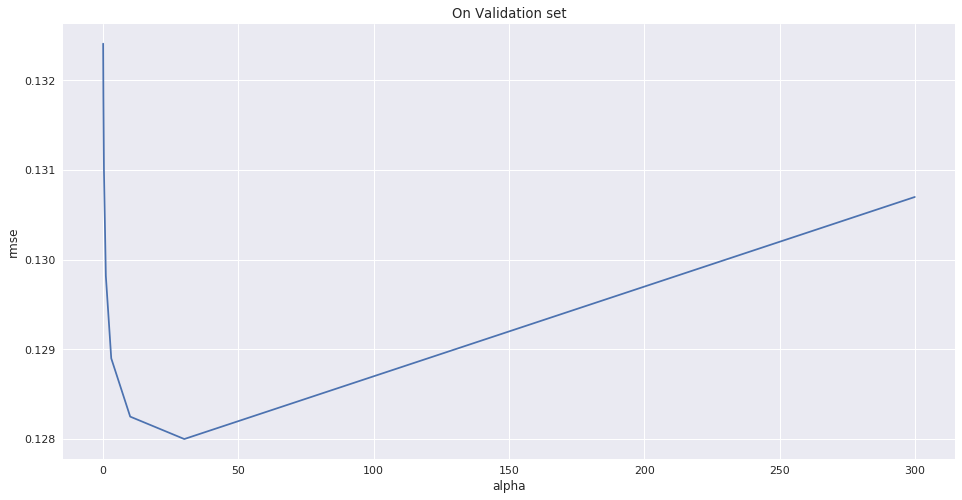

In [203]:
(ridge_alpha, _) = find_best_alpha(alphas=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300],
                                   model=Ridge)

*ElasticNet regression* -

Minimum RMSE = 0.12821 found at alpha = 0.001


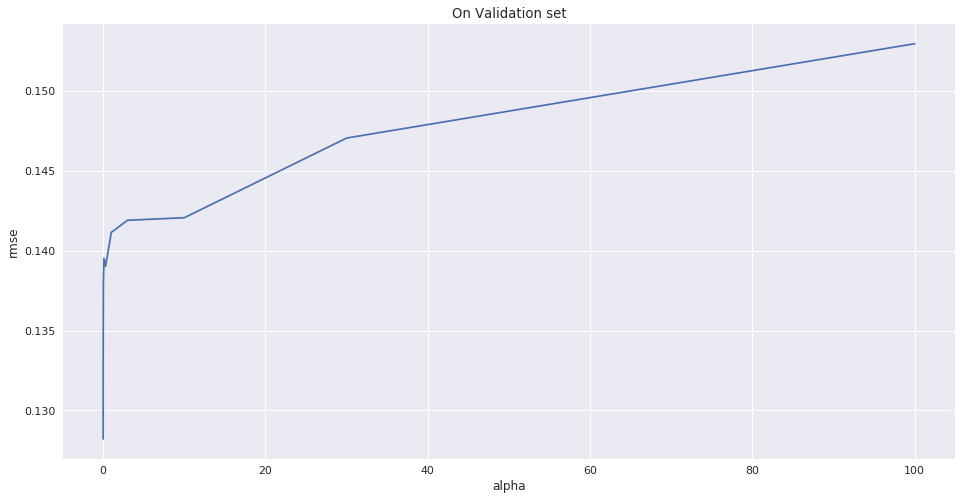

In [204]:
(elasticNet_alpha, _) = find_best_alpha(alphas=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30, 100],
                                        model=ElasticNet)

*Lasso Regression* -

Minimum RMSE = 0.12803 found at alpha = 0.001


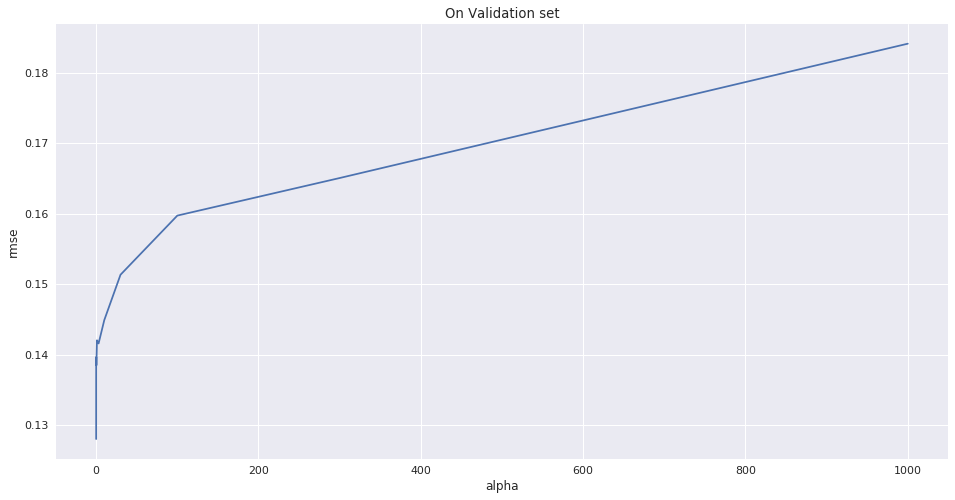

In [205]:
(lasso_alpha, _) = find_best_alpha(alphas=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30, 100, 300, 1000],
                                   model=Lasso)

#### Using `RandomizedSearchCV`

In [206]:
from sklearn.model_selection import RandomizedSearchCV

*Ridge Regression* -

In [207]:
ridge_random_grid = {'alpha': [int(x) for x in np.linspace(start=0.5*ridge_alpha, stop=1.5*ridge_alpha, num=10)],
                     'fit_intercept': [True],
                     'normalize': [True, False],
                     'copy_X': [True],
                     'max_iter': [10, 30, 100, 300, 1000, 3000, 10000],
                     'tol': [0.0001],
                     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                     'random_state': [42]}
ridge = Ridge()
ridge_random = RandomizedSearchCV(estimator = ridge, 
                                  param_distributions = ridge_random_grid, 
                                  n_iter = 100, 
                                  verbose=1, 
                                  random_state=42, 
                                  n_jobs = -1)

ridge_random.fit(X_train, Y_train_log)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'alpha': [15, 18, 21, 25, 28, 31, 35, 38, 41, 45], 'fit_intercept': [True], 'normalize': [True, False], 'copy_X': [True], 'max_iter': [10, 30, 100, 300, 1000, 3000, 10000], 'tol': [0.0001], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [208]:
print(rmse_score(Y_validate.values, ridge_random.best_estimator_.predict(X_validate)))

9.54741


In [209]:
ridge_random.best_params_

{'tol': 0.0001,
 'solver': 'auto',
 'random_state': 42,
 'normalize': False,
 'max_iter': 300,
 'fit_intercept': True,
 'copy_X': True,
 'alpha': 31}

*ElasticNet Regression* -

In [210]:
elasticNet_random_grid = {'alpha': [int(x) for x in np.linspace(start=0.5*elasticNet_alpha, 
                                                                stop=1.5*elasticNet_alpha, 
                                                                num=10)],
                          'l1_ratio': [0.01, 0.03, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                          'fit_intercept': [True],
                          'normalize': [True, False],
                          'precompute': [True, False],
                          'copy_X': [True],
                          'max_iter': [10, 30, 100, 300, 1000, 3000, 10000],
                          'tol': [0.0001],
                          'warm_start': [True, False],
                          'positive': [True, False],
                          'selection': ['cyclic', 'random'],
                          'random_state': [42]}

elastic_net = ElasticNet()
elastic_net_random = RandomizedSearchCV(estimator = elastic_net, 
                                  param_distributions = elasticNet_random_grid, 
                                  n_iter = 100, 
                                  verbose=1, 
                                  random_state=42, 
                                  n_jobs = -1)

elastic_net_random.fit(X_train, Y_train_log)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.7s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'alpha': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'l1_ratio': [0.01, 0.03, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 'fit_intercept': [True], 'normalize': [True, False], 'precompute': [True, False], 'copy_X': [True], 'max_iter': [10, 30, 100, 300, 1000, 3000, 10000], 'tol': [0.0001], 'warm_start': [True, False], 'positive': [True, False], 'selection': ['cyclic', 'random'], 'random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [211]:
print(rmse_score(Y_validate.values, elastic_net_random.best_estimator_.predict(X_validate)))

9.54723


In [212]:
elastic_net_random.best_params_

{'warm_start': True,
 'tol': 0.0001,
 'selection': 'cyclic',
 'random_state': 42,
 'precompute': True,
 'positive': True,
 'normalize': True,
 'max_iter': 1000,
 'l1_ratio': 0.9,
 'fit_intercept': True,
 'copy_X': True,
 'alpha': 0}

*Lasso Regression* -

In [213]:
lasso_random_grid = {'alpha': [int(x) for x in np.linspace(start=0.5*lasso_alpha, 
                                                                stop=1.5*lasso_alpha, 
                                                                num=10)],
                     'fit_intercept': [True],
                     'normalize': [True, False],
                     'precompute': [True, False],
                     'copy_X': [True],
                     'max_iter': [10, 30, 100, 300, 1000, 3000, 10000],
                     'tol': [0.0001],
                     'warm_start': [True, False],
                     'positive': [True, False],
                     'selection': ['cyclic', 'random'],
                     'random_state': [42]}

lasso = Lasso()
lasso_random = RandomizedSearchCV(estimator = lasso, 
                                  param_distributions = lasso_random_grid, 
                                  n_iter = 100, 
                                  verbose=1, 
                                  random_state=42, 
                                  n_jobs = -1)

lasso_random.fit(X_train, Y_train_log)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   28.4s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'alpha': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'fit_intercept': [True], 'normalize': [True, False], 'precompute': [True, False], 'copy_X': [True], 'max_iter': [10, 30, 100, 300, 1000, 3000, 10000], 'tol': [0.0001], 'warm_start': [True, False], 'positive': [True, False], 'selection': ['cyclic', 'random'], 'random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [214]:
print(rmse_score(Y_validate.values, lasso_random.best_estimator_.predict(X_validate)))

9.54723


In [215]:
lasso_random.best_params_

{'warm_start': False,
 'tol': 0.0001,
 'selection': 'cyclic',
 'random_state': 42,
 'precompute': True,
 'positive': True,
 'normalize': True,
 'max_iter': 1000,
 'fit_intercept': True,
 'copy_X': True,
 'alpha': 0}

#### Improving `Random Forest` -

The `Random Forest` model achieves the best accuracy (of __86.24%__ when I ran it locally) on the cross-validation set. 

**Note: _The huge difference between the `Cross-Validation Score`s of `Random Forest` and `XGBoost` as compared to`Decision_Tree` and the fact that the `Decision Tree` model reached ~100% accuracy on Training data, highlights that it is easy to overfit a `Decision Tree`. The former 2 being an ensemble of `Decision Tree`s, are inherently good at avoiding overfitting._**

Now, let's try to tweak the model to further improve it.

**Reducing the number of features:**

A general rule of thumb in Machine Learning is that the more features you have, the greater are the chances of your model overfitting the data. Extra features can decrease performance because they may “confuse” the model by giving it irrelevant data that prevents it from learning the actual relationships.

Scikit-learn's `RandomForestRegressor` has a useful attribute - `feature_importances_` - which gives each feature a score based on how important it is in the prediction process.

We use it to extract the `n`-best features upon which we train our final model.

We find the value of `n` by iteratively training the model on number of features in the multiple of 10s. Then, we take at the value which returned the best score on the validation set.

In [216]:
feature_importances = pd.DataFrame({
    'Features': X_train.columns,
    'Importances': random_forest.feature_importances_
})
feature_importances = feature_importances.sort_values(by='Importances', ascending=False)

In [217]:
best = {}

for feature_count in range(10, 210, 10):
    best[feature_count] = {'feature_list': list(feature_importances['Features'][:feature_count])}

In [218]:
for feature_set_size, features in best.items():
    train_accuracy_sum = 0
    validation_accuracy_sum = 0
    
    nattempts = 3
    for attempt in range(nattempts):
        
        X_train_best = X_train[features['feature_list']]
        X_validate_best = X_validate[features['feature_list']]
        X_test_best = X_test[features['feature_list']]

        random_forest = RandomForestRegressor(n_estimators=100)
        random_forest.fit(X_train_best, Y_train)

        acc_random_forest_train = rmse_score(Y_train.values, random_forest.predict(X_train_best))
        acc_random_forest_validate = rmse_score(Y_validate.values, random_forest.predict(X_validate_best))
        
        train_accuracy_sum += acc_random_forest_train
        validation_accuracy_sum += acc_random_forest_validate

    features['train_accuracy_avg'] = train_accuracy_sum/nattempts
    features['validation_accuracy_avg'] = validation_accuracy_sum/nattempts
    
    print("No. of features:", feature_set_size)
    print("Train accuracy: ", features['train_accuracy_avg'])
    print("Cross-Validation accuracy: ", features['validation_accuracy_avg'])

No. of features: 10
Train accuracy:  0.07190333333333333
Cross-Validation accuracy:  0.16764
No. of features: 20
Train accuracy:  0.05815666666666667
Cross-Validation accuracy:  0.14567666666666668
No. of features: 30
Train accuracy:  0.05571
Cross-Validation accuracy:  0.14320333333333335
No. of features: 40
Train accuracy:  0.05545
Cross-Validation accuracy:  0.14328666666666667
No. of features: 50
Train accuracy:  0.05626333333333333
Cross-Validation accuracy:  0.14164333333333334
No. of features: 60
Train accuracy:  0.05482666666666666
Cross-Validation accuracy:  0.13977333333333333
No. of features: 70
Train accuracy:  0.05443666666666667
Cross-Validation accuracy:  0.13860333333333333
No. of features: 80
Train accuracy:  0.05473
Cross-Validation accuracy:  0.13757
No. of features: 90
Train accuracy:  0.05538666666666667
Cross-Validation accuracy:  0.13857666666666665
No. of features: 100
Train accuracy:  0.05504666666666667
Cross-Validation accuracy:  0.13813
No. of features: 110


In [219]:
feature_sizes_sorted = sorted(best.keys(), 
                              key=lambda feature_count: best[feature_count]['validation_accuracy_avg'])
accuracies = [best[nfeatures]['validation_accuracy_avg'] for nfeatures in feature_sizes_sorted]

for nfeatures, accuracies in zip(feature_sizes_sorted, accuracies):
    print(nfeatures, ": ", round(accuracies, 5))

80 :  0.13757
150 :  0.13757
160 :  0.13767
130 :  0.13791
120 :  0.13803
200 :  0.13805
180 :  0.13812
100 :  0.13813
170 :  0.1383
110 :  0.13831
90 :  0.13858
70 :  0.1386
140 :  0.13875
190 :  0.13887
60 :  0.13977
50 :  0.14164
30 :  0.1432
40 :  0.14329
20 :  0.14568
10 :  0.16764


Okay, the best validation set RMSE of `0.13736`. This is almost the same as the accuracy I got using just the default model.

Well, it was a promising avenue to look into. So, its okay that it did not improve the results.

## Final submission model

For the final model, I am going to use those models that gave me an `RMS error < 0.13`i.e, __Ridge Regression__, __ElasticNet Regression__, __Lasso regression__ and the __XGBoost__ models.

I have found, through trial and error, that stacking **_all those models except the Lasso model_**, gives the best results.

In [220]:
Y_validate_lasso_in = (ridge_random.best_estimator_.predict(X_validate) +
                         elastic_net_random.best_estimator_.predict(X_validate) +
                         lasso_random.best_estimator_.predict(X_validate) +
                         xgboost.predict(X_validate)) / 4

In [221]:
Y_validate_lasso_out = (ridge_random.best_estimator_.predict(X_validate) +
                         elastic_net_random.best_estimator_.predict(X_validate) +
                         #lasso_random.best_estimator_.predict(X_validate) +
                         xgboost.predict(X_validate)) / 3

In [222]:
rmse_score(Y_validate.values, Y_validate_lasso_in)

1.38257

In [223]:
rmse_score(Y_validate.values, Y_validate_lasso_out)

1.09644

Now train the final model on the entire training set.

In [224]:
final_train = all_data[:ntrain+nvalidate][:]
final_test = all_data[ntrain+nvalidate:][:]

final_train_X = final_train.drop('SalePrice', axis= 1)
final_train_Y = final_train['SalePrice']
final_train_Y_log = SalePriceLog
final_test_X = final_test.drop('SalePrice', axis=1)

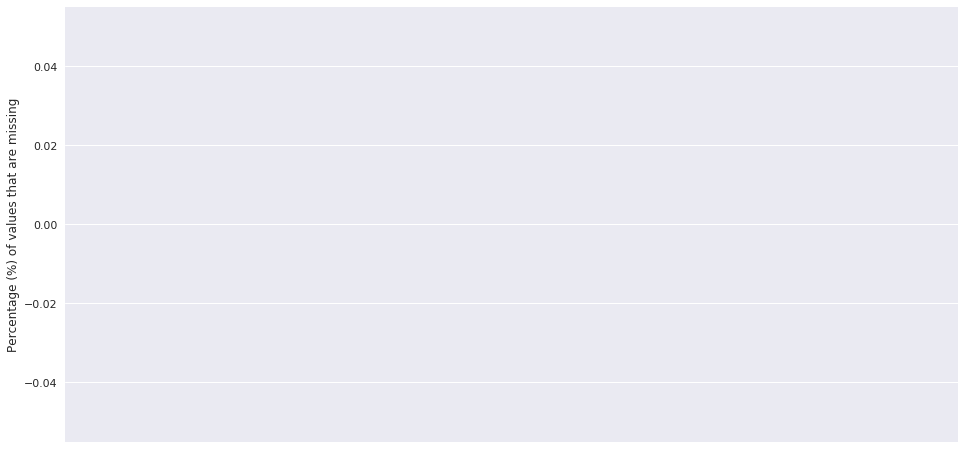

In [225]:
# make sure there are no missing features
missing_features(final_train_X, final_train_X.columns)

In [226]:
ridge_random_grid = {'alpha': [int(x) for x in np.linspace(start=0.5*ridge_alpha, stop=1.5*ridge_alpha, num=10)],
                     'fit_intercept': [True],
                     'normalize': [True, False],
                     'copy_X': [True],
                     'max_iter': [10, 30, 100, 300, 1000, 3000, 10000],
                     'tol': [0.0001],
                     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                     'random_state': [42]}
ridge = Ridge()
ridge_random = RandomizedSearchCV(estimator = ridge, 
                                  param_distributions = ridge_random_grid, 
                                  n_iter = 100, 
                                  verbose=1, 
                                  random_state=42, 
                                  n_jobs = -1)

ridge_random.fit(final_train_X, final_train_Y_log)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'alpha': [15, 18, 21, 25, 28, 31, 35, 38, 41, 45], 'fit_intercept': [True], 'normalize': [True, False], 'copy_X': [True], 'max_iter': [10, 30, 100, 300, 1000, 3000, 10000], 'tol': [0.0001], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [227]:
elasticNet_random_grid = {'alpha': [int(x) for x in np.linspace(start=0.5*elasticNet_alpha, 
                                                                stop=1.5*elasticNet_alpha, 
                                                                num=10)],
                          'l1_ratio': [0.01, 0.03, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                          'fit_intercept': [True],
                          'normalize': [True, False],
                          'precompute': [True, False],
                          'copy_X': [True],
                          'max_iter': [10, 30, 100, 300, 1000, 3000, 10000],
                          'tol': [0.0001],
                          'warm_start': [True, False],
                          'positive': [True, False],
                          'selection': ['cyclic', 'random'],
                          'random_state': [42]}

elastic_net = ElasticNet()
elastic_net_random = RandomizedSearchCV(estimator = elastic_net, 
                                  param_distributions = elasticNet_random_grid, 
                                  n_iter = 100, 
                                  verbose=1, 
                                  random_state=42, 
                                  n_jobs = -1)

elastic_net_random.fit(final_train_X, final_train_Y_log)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   31.2s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'alpha': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'l1_ratio': [0.01, 0.03, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 'fit_intercept': [True], 'normalize': [True, False], 'precompute': [True, False], 'copy_X': [True], 'max_iter': [10, 30, 100, 300, 1000, 3000, 10000], 'tol': [0.0001], 'warm_start': [True, False], 'positive': [True, False], 'selection': ['cyclic', 'random'], 'random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [228]:
xgboost = XGBRegressor()
xgboost.fit(final_train_X, final_train_Y_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [229]:
rmse_score(final_train_Y.values, ridge_random.best_estimator_.predict(final_train_X))

9.54272

In [230]:
rmse_score(final_train_Y.values, elastic_net_random.best_estimator_.predict(final_train_X))

9.54273

In [231]:
rmse_score(final_train_Y.values, xgboost.predict(final_train_X))

9.54273

The final predicted values - 

In [232]:
final_Y_pred = np.exp((ridge_random.best_estimator_.predict(final_test_X) +
                   elastic_net_random.best_estimator_.predict(final_test_X) +
                   xgboost.predict(final_test_X)) / 3)

In [233]:
submission = pd.DataFrame({'Id': test_id,
                           'SalePrice': final_Y_pred})
submission.to_csv('submission.csv', index=False)